# Getting Dataset Instances

Now that your local system is set up, we can examine some of the dataset instances.

We'll cover downloading an instance, loading the data, and some initial looks at the data.

## Downloading an Instance

Two datasets are provided: a low-resolution $\text{N}_\text{side}=128$ and a higher resolution $\text{N}_\text{side}=512$ dataset. It's faster and easier to work with the lower resolution dataset, so we'll use that for the first few examples here. We'll use the higher resolution dataset at the end as well.

First, we'll set up the configuration, by loading it from a config file.

In [1]:
import os
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

# Set the environment variable, only effective for this notebook.
os.environ['CMB_ML_LOCAL_SYSTEM'] = 'jim_lab'
hydra.core.global_hydra.GlobalHydra.instance().clear() # if re-initialize is needed, clear the global hydra instance (in case of multiple calls to initialize)

initialize(version_base=None, config_path="../cfg")

cfg = compose(config_name='config_demo_dataset.yaml',
              overrides=['nside=128', 'map_fields="I"'])

In [2]:
print(OmegaConf.to_yaml(cfg, resolve=True))

local_system:
  datasets_root: /data/jim/CMB_Data/Datasets/
  assets_dir: /data/jim/CMB_Data/Assets/
file_system:
  sim_folder_prefix: sim
  sim_str_num_digits: 4
  dataset_template_str: '{root}/{dataset}/'
  default_dataset_template_str: '{root}/{dataset}/{stage}/{split}/{sim}'
  working_dataset_template_str: '{root}/{dataset}/{working}{stage}/{split}/{sim}'
  subdir_for_log_scripts: scripts
  log_dataset_template_str: '{root}/{dataset}/{hydra_run_dir}'
  log_stage_template_str: '{root}/{dataset}/{working}{stage}/{hydra_run_dir}'
  top_level_work_template_str: '{root}/{dataset}/{stage}/{hydra_run_dir}'
  wmap_chains_dir: WMAP/wmap_lcdm_mnu_wmap9_chains_v5
scenario:
  nside: 128
  detector_freqs:
  - 30
  - 44
  - 70
  - 100
  - 143
  - 217
  - 353
  - 545
  - 857
  map_fields: I
  precision: float
  units: K_CMB
  full_instrument:
    30: IQU
    44: IQU
    70: IQU
    100: IQU
    143: IQU
    217: IQU
    353: IQU
    545: I
    857: I
splits:
  name: '1450'
  Train:
    n_sims: 20

We'll use just the first data instance, simulation 0 from the Train split.

In [3]:
dataset_name = cfg.dataset_name
split = "Train"
sim_num = 0

Get the paths for the source and destination.

In [4]:
# The source is defined in the box_info json files
json_file = f"../shared_link_jsons/box_info_{dataset_name}.json"

print(json_file)

../shared_link_jsons/box_info_I_128_1450.json


In [5]:
# The destination is provided by a Namer object, which pulls from the hydra config
from cmbml.core import Namer

namer = Namer(cfg)
path_template = cfg.file_system.default_dataset_template_str
context_params = dict(
    dataset=dataset_name,
    stage="Simulation",
    split=split,
    sim_num=sim_num
)
with namer.set_contexts(context_params):
    dest = namer.path(path_template)

print(dest)

/data/jim/CMB_Data/Datasets/I_128_1450/Simulation/Train/sim0000


And download the data

In [6]:
from data_acquisition.use_shared_links import get_data_one_instance

get_data_one_instance(json_file, dest, split, sim_num)

## NOTE: FEEDBACK WANTED

I don't know if it would be better to write out all the steps instead of a single magic function.

# Looking at the Data

There's a couple ways we can look at the acquired data. Let's first see the most intuitive form: sky maps. We have maps for both CMB and the observations; we'll demonstrate utilities for looking at both.

First, the CMB.

In [7]:
import healpy as hp
from cmbml.core.asset_handlers.healpy_map_handler import HealpyMap

In [8]:
map_handler = HealpyMap()
# _fid is for "fiducial" map; the authors have since adopted the use of the term "realization" instead.
#   This is an unfortunate relic that we hope to fix.
cmb_map_path = dest / "cmb_map_fid.fits"

The map handler returns a numpy array with shape $\text{N}_\text{fields} \times \text{N}_\text{side}$. Map fields refers to having either only temperature (I) or temperature and polarization data (IQU), so $\text{N}_\text{fields}$ is either 1 or 3. We're just going to consider temperature fields.

In [9]:
cmb_map = map_handler.read(cmb_map_path)
cmb_T_map = cmb_map[0]  # [0] to get the Temperature (Intensity) map

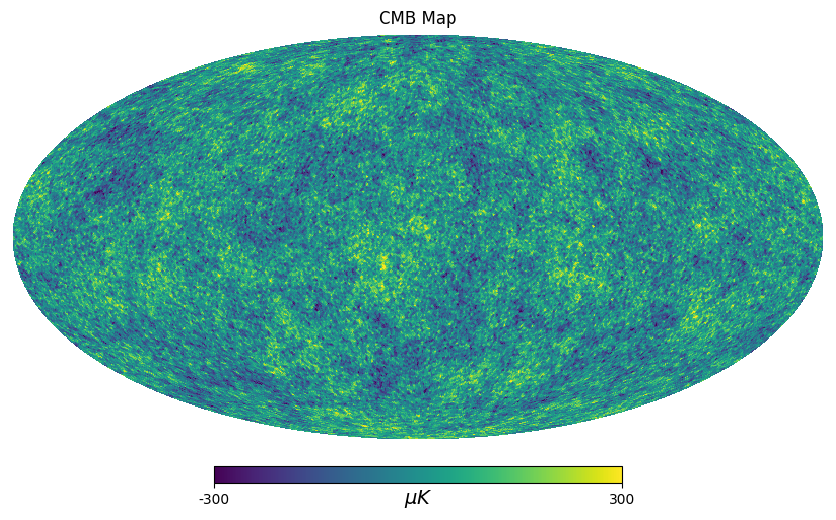

In [10]:
hp.mollview(cmb_T_map, title="CMB Map", cbar=True, unit="$\mu K$", min=-300, max=300)

Let's look at the 100 GHz observation first.

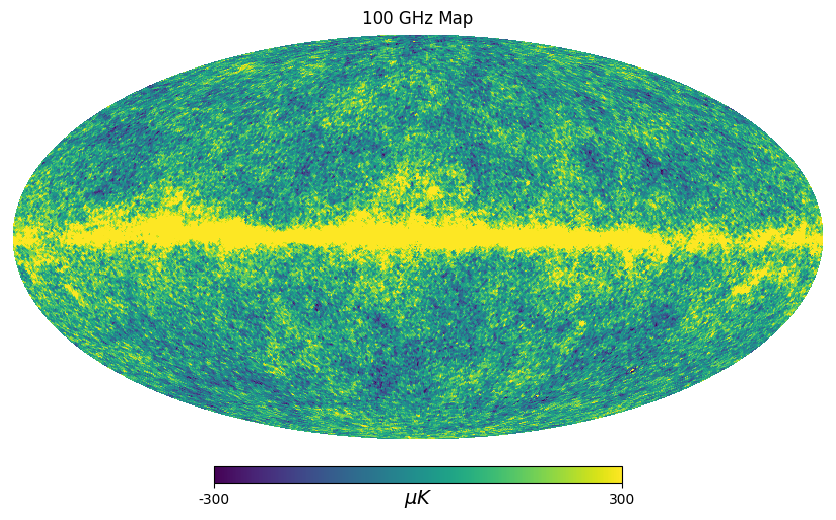

In [11]:
map_100GHz_path = dest / "obs_100_map.fits"
map_100GHz = map_handler.read(map_100GHz_path)[0] * 1e6
hp.mollview(map_100GHz, title="100 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=300)

We still see a lot of the CMB signal showing through. Observations at other frequencies have more foreground signal.

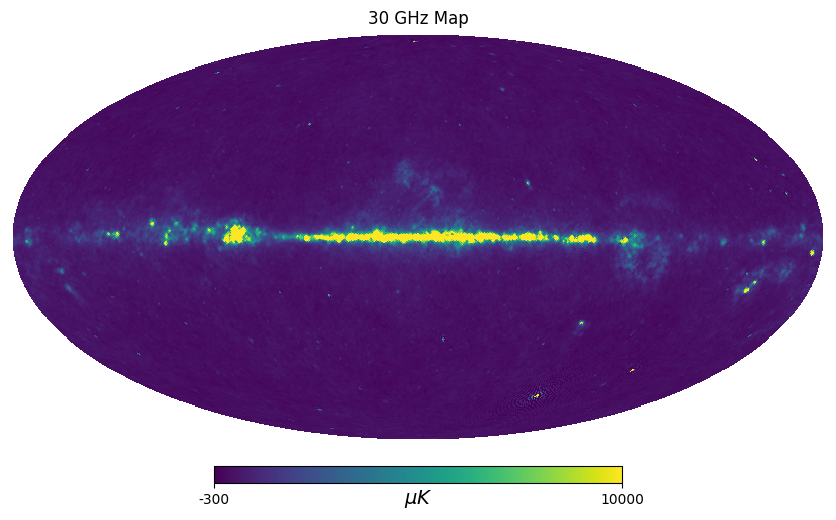

In [12]:
map_30GHz_path = dest / "obs_30_map.fits"
map_30GHz = map_handler.read(map_30GHz_path)[0] * 1e6
hp.mollview(map_30GHz, title="30 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=10000)

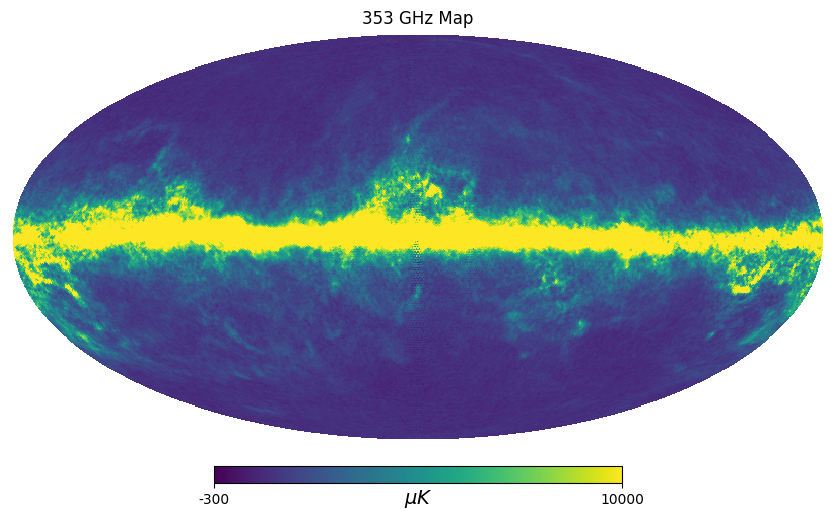

In [13]:
map_353GHz_path = dest / "obs_353_map.fits"
map_353GHz = map_handler.read(map_353GHz_path)[0] * 1e6
hp.mollview(map_353GHz, title="353 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=10000)

Note that the scale bars have had to change to accomodate the different intensity of these contaminants.

The impact of these foregrounds is described in a chart from the Planck Collaboration's 2015 X publication<sup id="a1">[1](#f1)</sup>, in Figure 51, reproduced here:

![Foreground contaminant signal strength](../assets/SEDs.png)

# Power Spectra

The map information is also commonly viewed in the spherical harmonics domain, as power spectra.

In [14]:
from cmbml.utils.physics_ps import get_auto_ps_result

We get the power spectrum as a PowerSpectrum object. There is some ambiguity involved with power spectra and the way they've been processed. This object helps keep things straight.

In this case, we want the "deconvolved" and "scaled" spectrum. We know the map is ground truth, and so there's no convolution to simulate instrumentation effects. We're also plotting the $\text{D}_\ell$, where $\text{D}_\ell = \frac{\ell(\ell+1)}{2\pi} \text{C}_\ell$ is a scaled form which is easier to view. Thus, we use the `.deconv_dl` property of the object.

<a id="128_power_spectra_calc"></a>

In [15]:
cmb_ps = get_auto_ps_result(cmb_T_map,
                            lmax=3*cfg.nside    # The resolution of the map is a bandwidth limit of the signal. The lmax is a representation of that.
                                                # The typical value is 3 * N_side
                            )
# We want the Deconvolved Dl, as explained in the above markdown cell.
cmb_ps = cmb_ps.deconv_dl

In [16]:
import matplotlib.pyplot as plt
import numpy as np

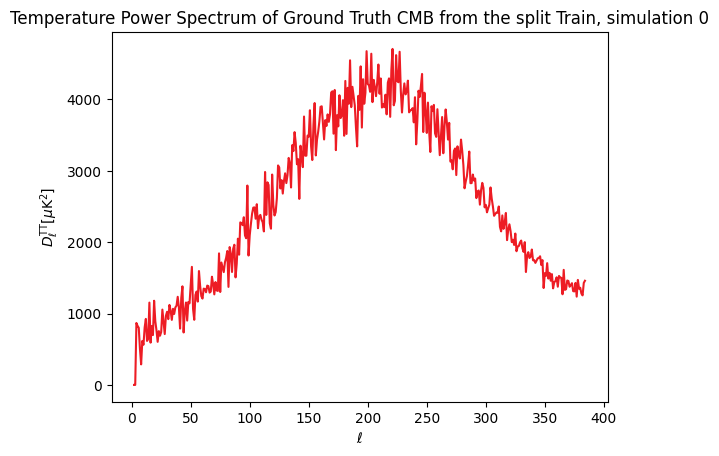

In [17]:
plot_params = dict(color="#ED1C24", label='Realization')

ylabel_rel = '$\\%\\Delta D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$'
ells = np.arange(cmb_ps.shape[0])

cmb_ps = cmb_ps[2:]
ells = ells [2:]

plt.plot(ells, cmb_ps, **plot_params)
plt.ylabel('$D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$')
plt.title(f'Temperature Power Spectrum of Ground Truth CMB from the split {split}, simulation {sim_num}')
plt.xlabel('$\\ell$');

It may not look exactly like what you expect (from Planck's official results<sup id="a2">[2](#f2)</sup>):

![Planck's official power spectrum](../assets/Planck_Power_Spectrum_pillars.jpg)

There are a few reasons for this. The first of these is scale. We've used a smaller asset ($\text{N}_\text{side}=128$) for demonstration, which only contains meaningful information up to roughly $3 \times \text{N}_\text{side} = 384$, though accuracy decreases above $2\times \text{N}_\text{side}$. Note that in the image above, the top axis is labelled $\ell$, and the horizontal axis is split, using logarithmic scaling below $\ell=30$.

The second, causing the jaggedness, is that this map is a realization (random instantiation) of the CMB map from the ground truth theory power spectrum. There's much more to discuss on the implications of how to properly compare model performance in light of this.

# Looking at the Data II: 512 Resolution Maps

For comparison, we load and show an instance from the main dataset, IQU-512-1450. Each instance for this dataset is 600 MB, as compared to the 40 MB for the I-128-1450 dataset.

In [18]:
# Reset the global state, just for tidyness sake.

%reset

In [19]:
import os
os.environ['CMB_ML_LOCAL_SYSTEM'] = 'jim_lab'

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from cmbml.core import Namer
from cmbml.core.asset_handlers.healpy_map_handler import HealpyMap
from cmbml.utils.physics_ps import get_auto_ps_result
from data_acquisition.use_shared_links import get_data_one_instance

The following cell sets up access to the dataset.

In [20]:
# Reinitialize Hydra, just in case
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../cfg")

# Load a config with resolution 512 information
cfg = compose(config_name='config_demo_dataset.yaml',
              overrides=['nside=512', 'map_fields="IQU"'])

dataset_name = cfg.dataset_name
split = "Train"
sim_num = 0

json_file = f"../shared_link_jsons/box_info_{dataset_name}.json"

namer = Namer(cfg)
path_template = cfg.file_system.default_dataset_template_str
context_params = dict(
    dataset=dataset_name,
    stage="Simulation",
    split=split,
    sim_num=sim_num,
)

with namer.set_contexts(context_params):
    dest = namer.path(path_template)

Download the dataset (which includes ensuring the MD5 checksum matches, extracting data from the archive, and deleting the tar archive).

In [21]:
get_data_one_instance(json_file, dest, split, sim_num)  # This file is ~600 MB

The map does not look much different; the differences are at finer scales.

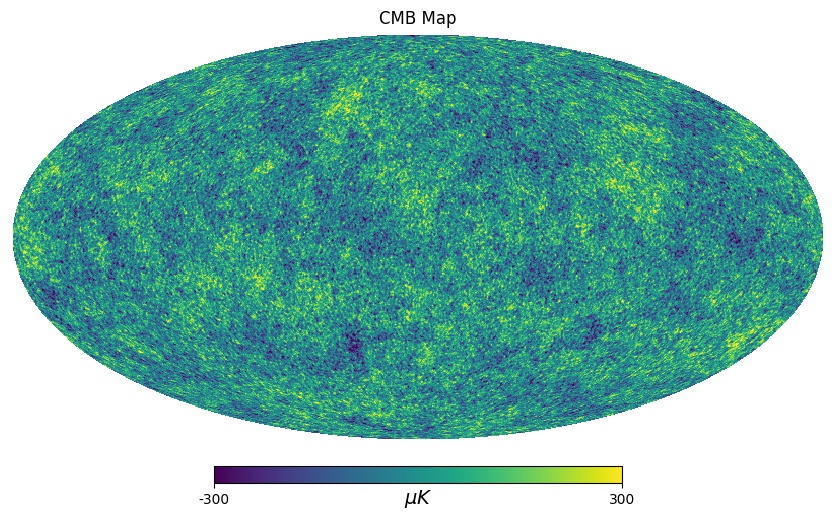

In [22]:
map_handler = HealpyMap()
cmb_map = map_handler.read(dest / "cmb_map_fid.fits")
cmb_T_map = cmb_map[0]  # [0] to get the Temperature (Intensity) map
hp.mollview(cmb_T_map, title="CMB Map", cbar=True, unit="$\mu K$", min=-300, max=300)

The power spectrum reveals the differences. For the curious, try running the cell in the 128 section of this notebook ([link](#128_power_spectra_calc)), but change the lmax to `12*cfg.nside`; note that you'll have to restart your kernel and rerun all cells above it. For the-only-sorta-curious: it's messed up.

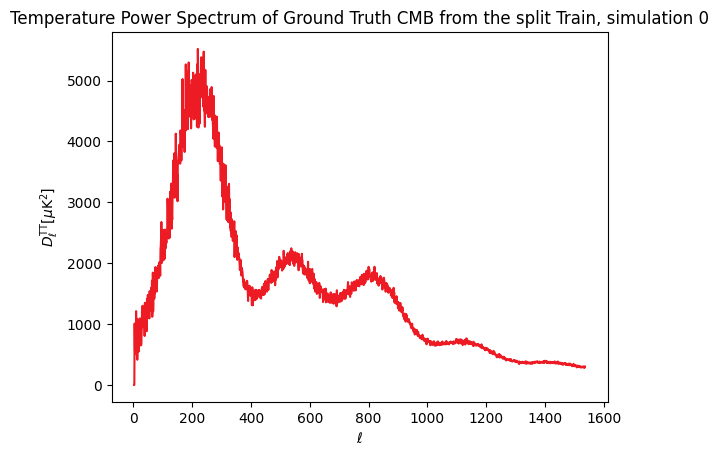

In [23]:
cmb_ps = get_auto_ps_result(cmb_T_map,
                            lmax=3*cfg.nside)

cmb_ps = cmb_ps.deconv_dl

plot_params = dict(color="#ED1C24", label='Realization')
ylabel_rel = '$\\%\\Delta D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$'
ells = np.arange(cmb_ps.shape[0])

cmb_ps = cmb_ps[2:]
ells = ells [2:]

plt.plot(ells, cmb_ps, **plot_params)
plt.ylabel('$D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$')
plt.title(f'Temperature Power Spectrum of Ground Truth CMB from the split {split}, simulation {sim_num}')
plt.xlabel('$\\ell$');

# Conclusion

We've downloaded data and gotten a small preview of how to look at it.

We hope, in the future, to provide more in-depth looks at using models and analysis code. For now, take a look in the executors for the various pipelines in `cmbml/<pipeline>/stage_executors`, for each of the `cmbnncs_local`, `pyilc_local`, and `analysis` pipelines.

Now, when you download the rest of the dataset, you'll be a bit more familiar with what you see.

Either:
- Download the [IQU-512-1450 manually](https://utdallas.box.com/v/cmb-ml-IQU-512-1450)
- Use the script [IQU-512-1450 script](../get_data/get_box_cmb-ml-IQU-512-1450.py)
- Use the script [I-128-1450 script](../get_data/get_box_cmb-ml-I-128-1450.py)
- Or generate your own simulations using [main_sims.py](../main_sims.py)

## References

<p id="f1"><sup><a href="#a1">1</a></sup> R. Adam, P. A. Ade, N. Aghanim, M. Alves, M. Arnaud, M. Ashdown, J. Aumont, C. Baccigalupi, A. Banday, R. Barreiro, et al. Planck 2015 Results-X. Diffuse Component Separation Foreground Maps. Astronomy & Astrophysics, 594:A10, 2016

<p id="f2"><sup><a href="#a2">2</a></sup> <a href="https://www.esa.int/ESA_Multimedia/Images/2013/03/Planck_Power_Spectrum">https://www.esa.int/ESA_Multimedia/Images/2013/03/Planck_Power_Spectrum</a>